Este archivo esta hecho de datos de los años 1996 y 2020

Contiene 7 columnas que especifican el puerto y su código único, la frontera, el modo de vehículo utilizado, el número de personas que cruzan la frontera hacia los EE. UU., la fecha y hora de cruce, el estado en el que entraron.



Introduccion

El proposito de este .ipynb es explorar series de tiempo para resolver las siguientes preguntas:

¿Que tipo de Trend de los cruces fronterizos?
¿Hay una estacionalidad coherente?
¿Hay picos o caídas agudas inesperadas? Si es así, ¿por qué?
¿Qué frontera y estado está más ocupado que otros?
Y algunas cosas mas, pero primero....

Importamos todas las librerias necesarias.

In [24]:
##imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

##
import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

warnings. filterwarnings("ignore")
plt.style.use('fivethirtyeight')

!pip install prophet
from prophet import Prophet

In [8]:
path = "/Users/morenx/grind/Border_Crossing_Entry_Data.csv"
data = pd.read_csv(path)
data.shape

(355511, 7)

Confirmamos que estructura tiene este csv.

In [9]:
data.sample()

,Port Name,State,Port Code,Border,Date,Measure,Value
228196,Eastport,ID,3302,US-Canada Border,6/1/2004 00:00,Buses,23


In [10]:
##formato de fecha y hora
data["Date"] = pd.to_datetime(data["Date"])

In [12]:
#Asignamos un nombre apropiado (informativo) al atributo Value:

data.rename(columns = {"Value": "Total Entries"},
            inplace= True)

In [13]:
##feature engineer en fechas
data["Year"] = data ["Date"].dt.year
data["Month"] = data ["Date"].dt.month

Visualizacion de data 
En series de tiempo, hay un metodo llamado rolling mean.
Este sirve para suavizar los datos y observar mejor el trend, reduciendo el ruido de las fluctuaciones que pueda tener los datos.

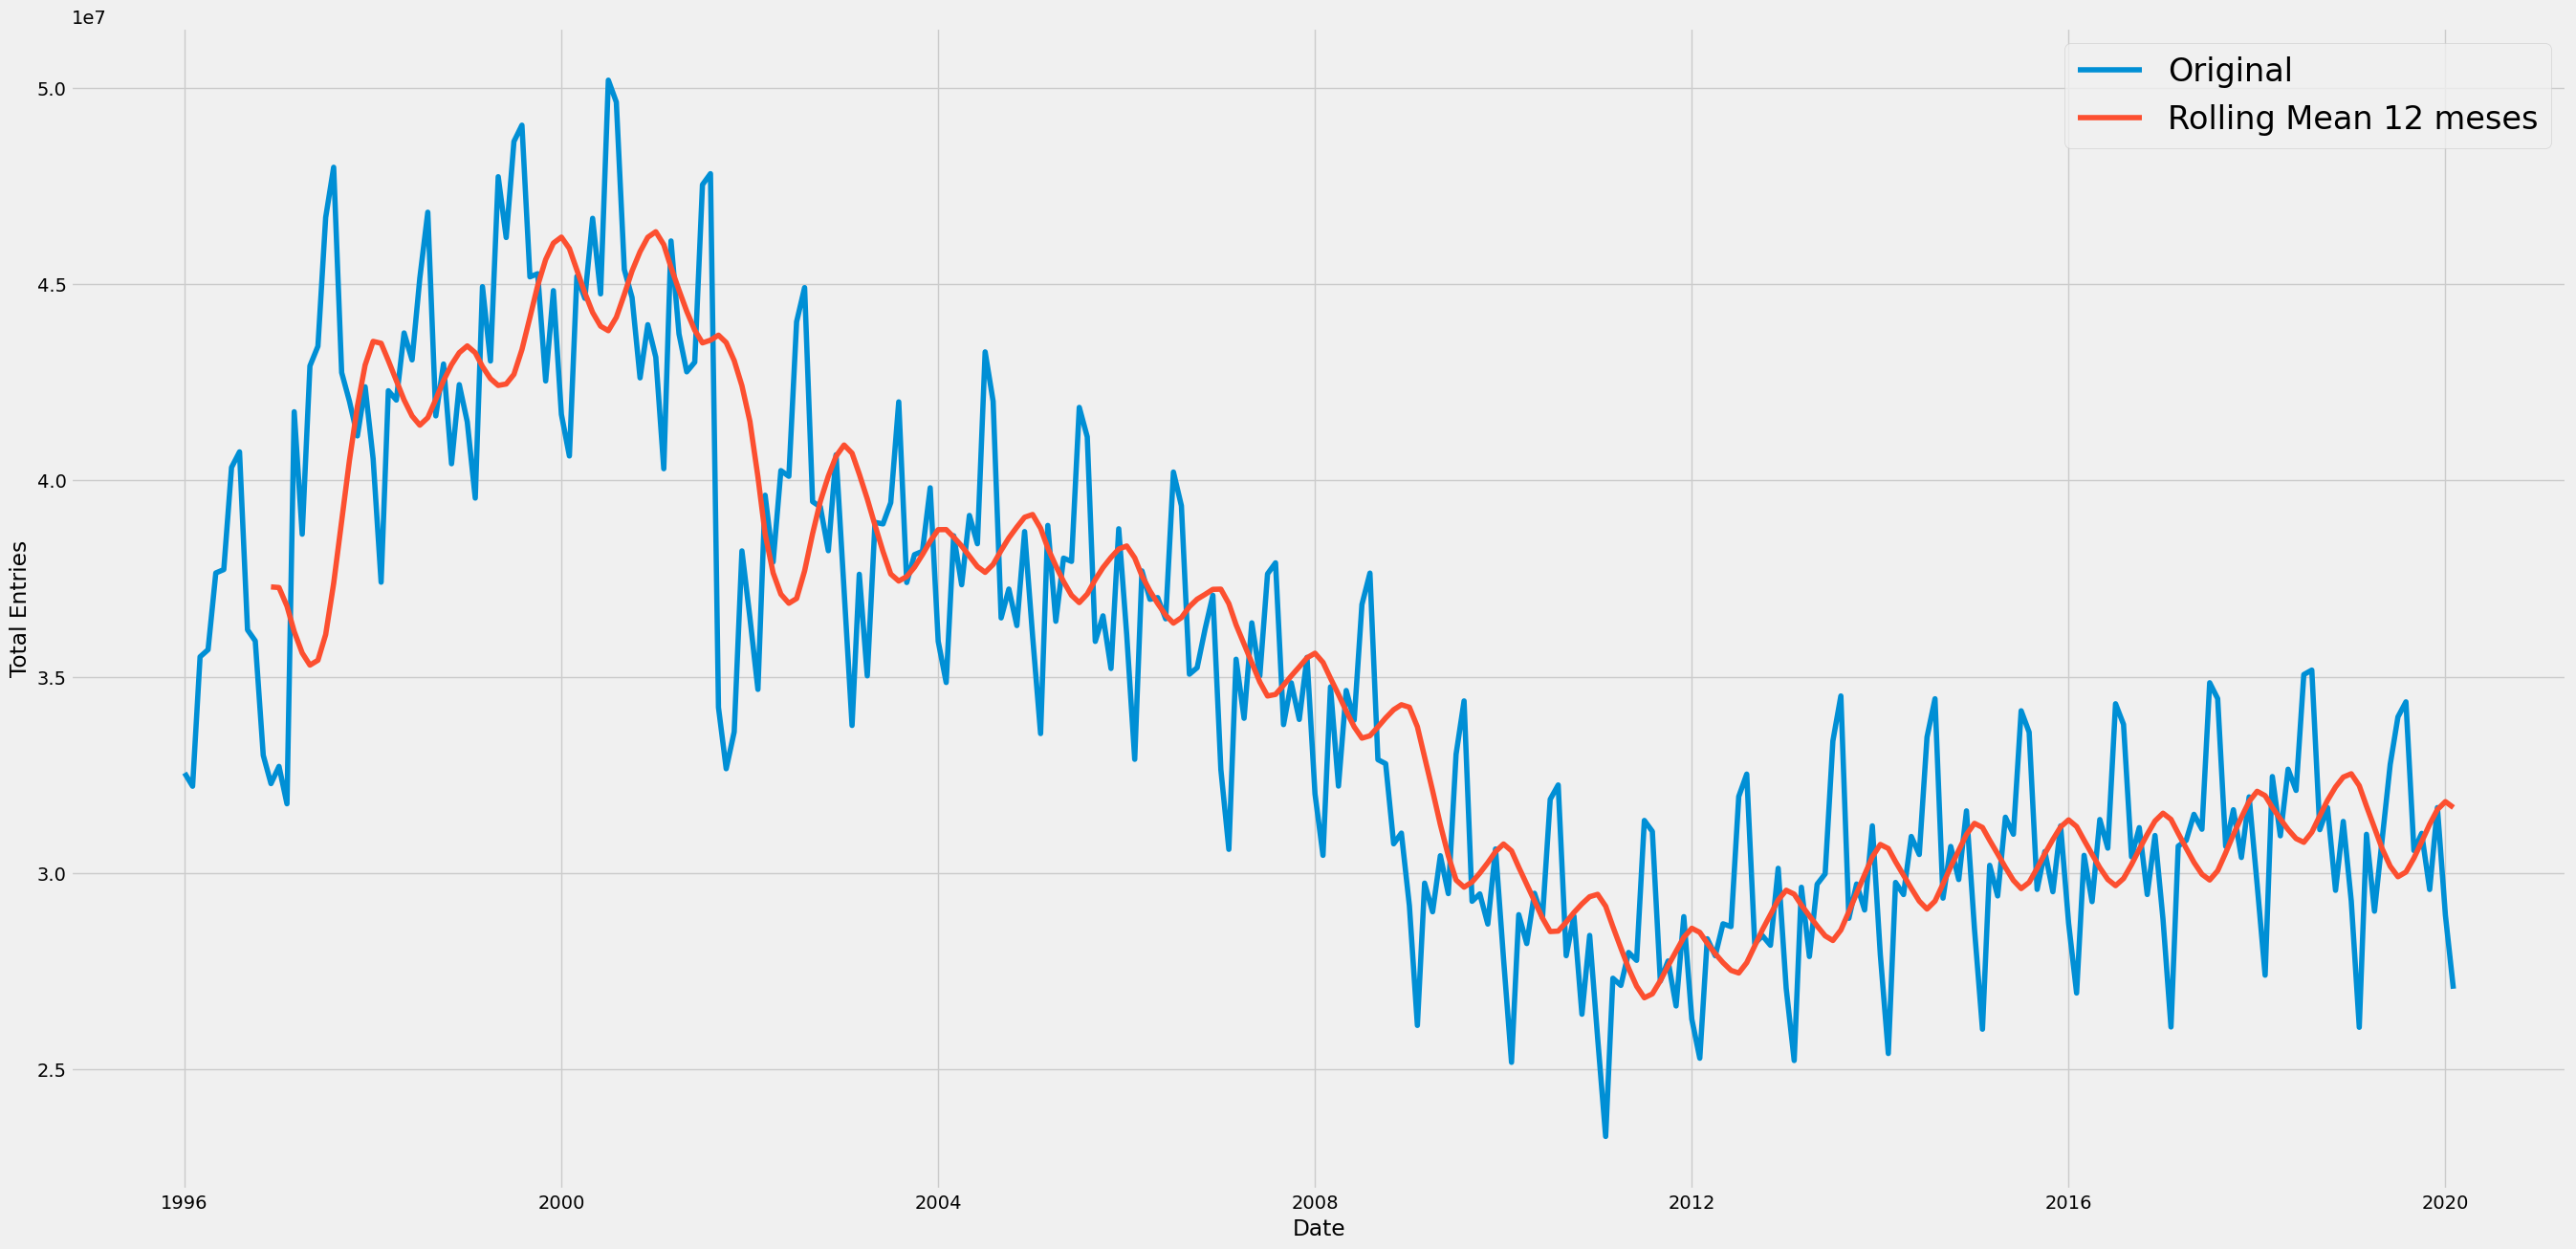

In [17]:
crossing = data[['Date', 'Total Entries']].groupby('Date').sum()
tseries = data.groupby(['Date'])['Total Entries'].agg(
    ['sum']).reset_index().rename(columns={'sum': 'Total Entries'})

tseries = tseries.set_index('Date')

fig = plt.subplots(figsize=(30, 15))

g = sns.lineplot(x=tseries.index, y='Total Entries',
                 data=tseries, label="Original")

rmean = crossing.rolling(12, win_type='triang').mean()

g = sns.lineplot(x=rmean.index, y='Total Entries',
                 data=rmean, label="Rolling Mean 12 meses")

plt.legend(fontsize='xx-large')
plt.show()

Como se puede ver, en los datos, hay como tres etapas donde se puede ver que podria ver cierta estacionalidad.
La primera entre los años 97 y 98, ni idea de porque se daria
Otra es entre los años 2001 y 2002, no estoy seguro pero tal vez se deba al 911
La ultima es de los años 2008 y 2009, no sabia a que se podria deber, pero busque en google y al parecer en el 2008 hubo una problematica llamada Crisis Financiera Global 

Sigamos viendo componentes de esta serie de tiempo:

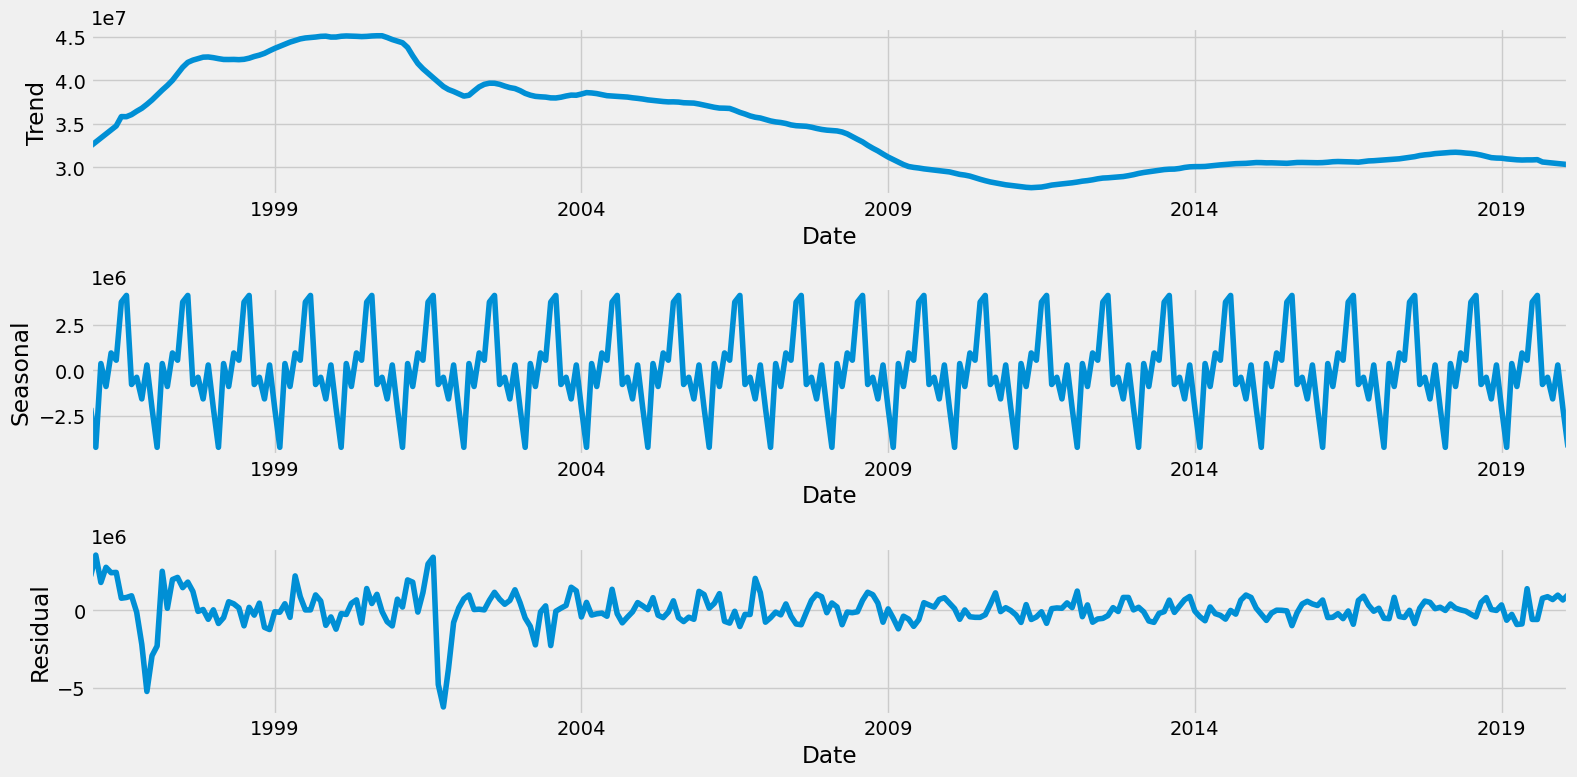

In [22]:
## descomponemos los datos

decompose = sm.tsa.seasonal_decompose(tseries, model = "additive",
                                        extrapolate_trend= "freq")

#plt
fig, axes = plt.subplots(nrows=3, figsize=(16,8))

decompose.trend.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Trend')

decompose.seasonal.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Seasonal')

decompose.resid.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Residual')


plt.tight_layout()
plt.show()

El subplot de la estacionalidad tiene un patron muy repetitivo con una amplitud relativamente constante. Este componente podria indicar que los datos tienen fluctuaciones regulares dentro de un periodo de tiempo fijo (mensual o trimestral).

El sublot de trend no es constante, este factor podria decirnos que no es estacionaria (media no constante).
Si es que quiero aplicar un modelo para sacar mas informacion, necesitaria diferenciar la serie para hacer que trend sea sea estacionario.

A diferenciarilo me refiero a restar el valor anterior para eliminar trend o no estacionariedad

ENTRADAS MENSUALES

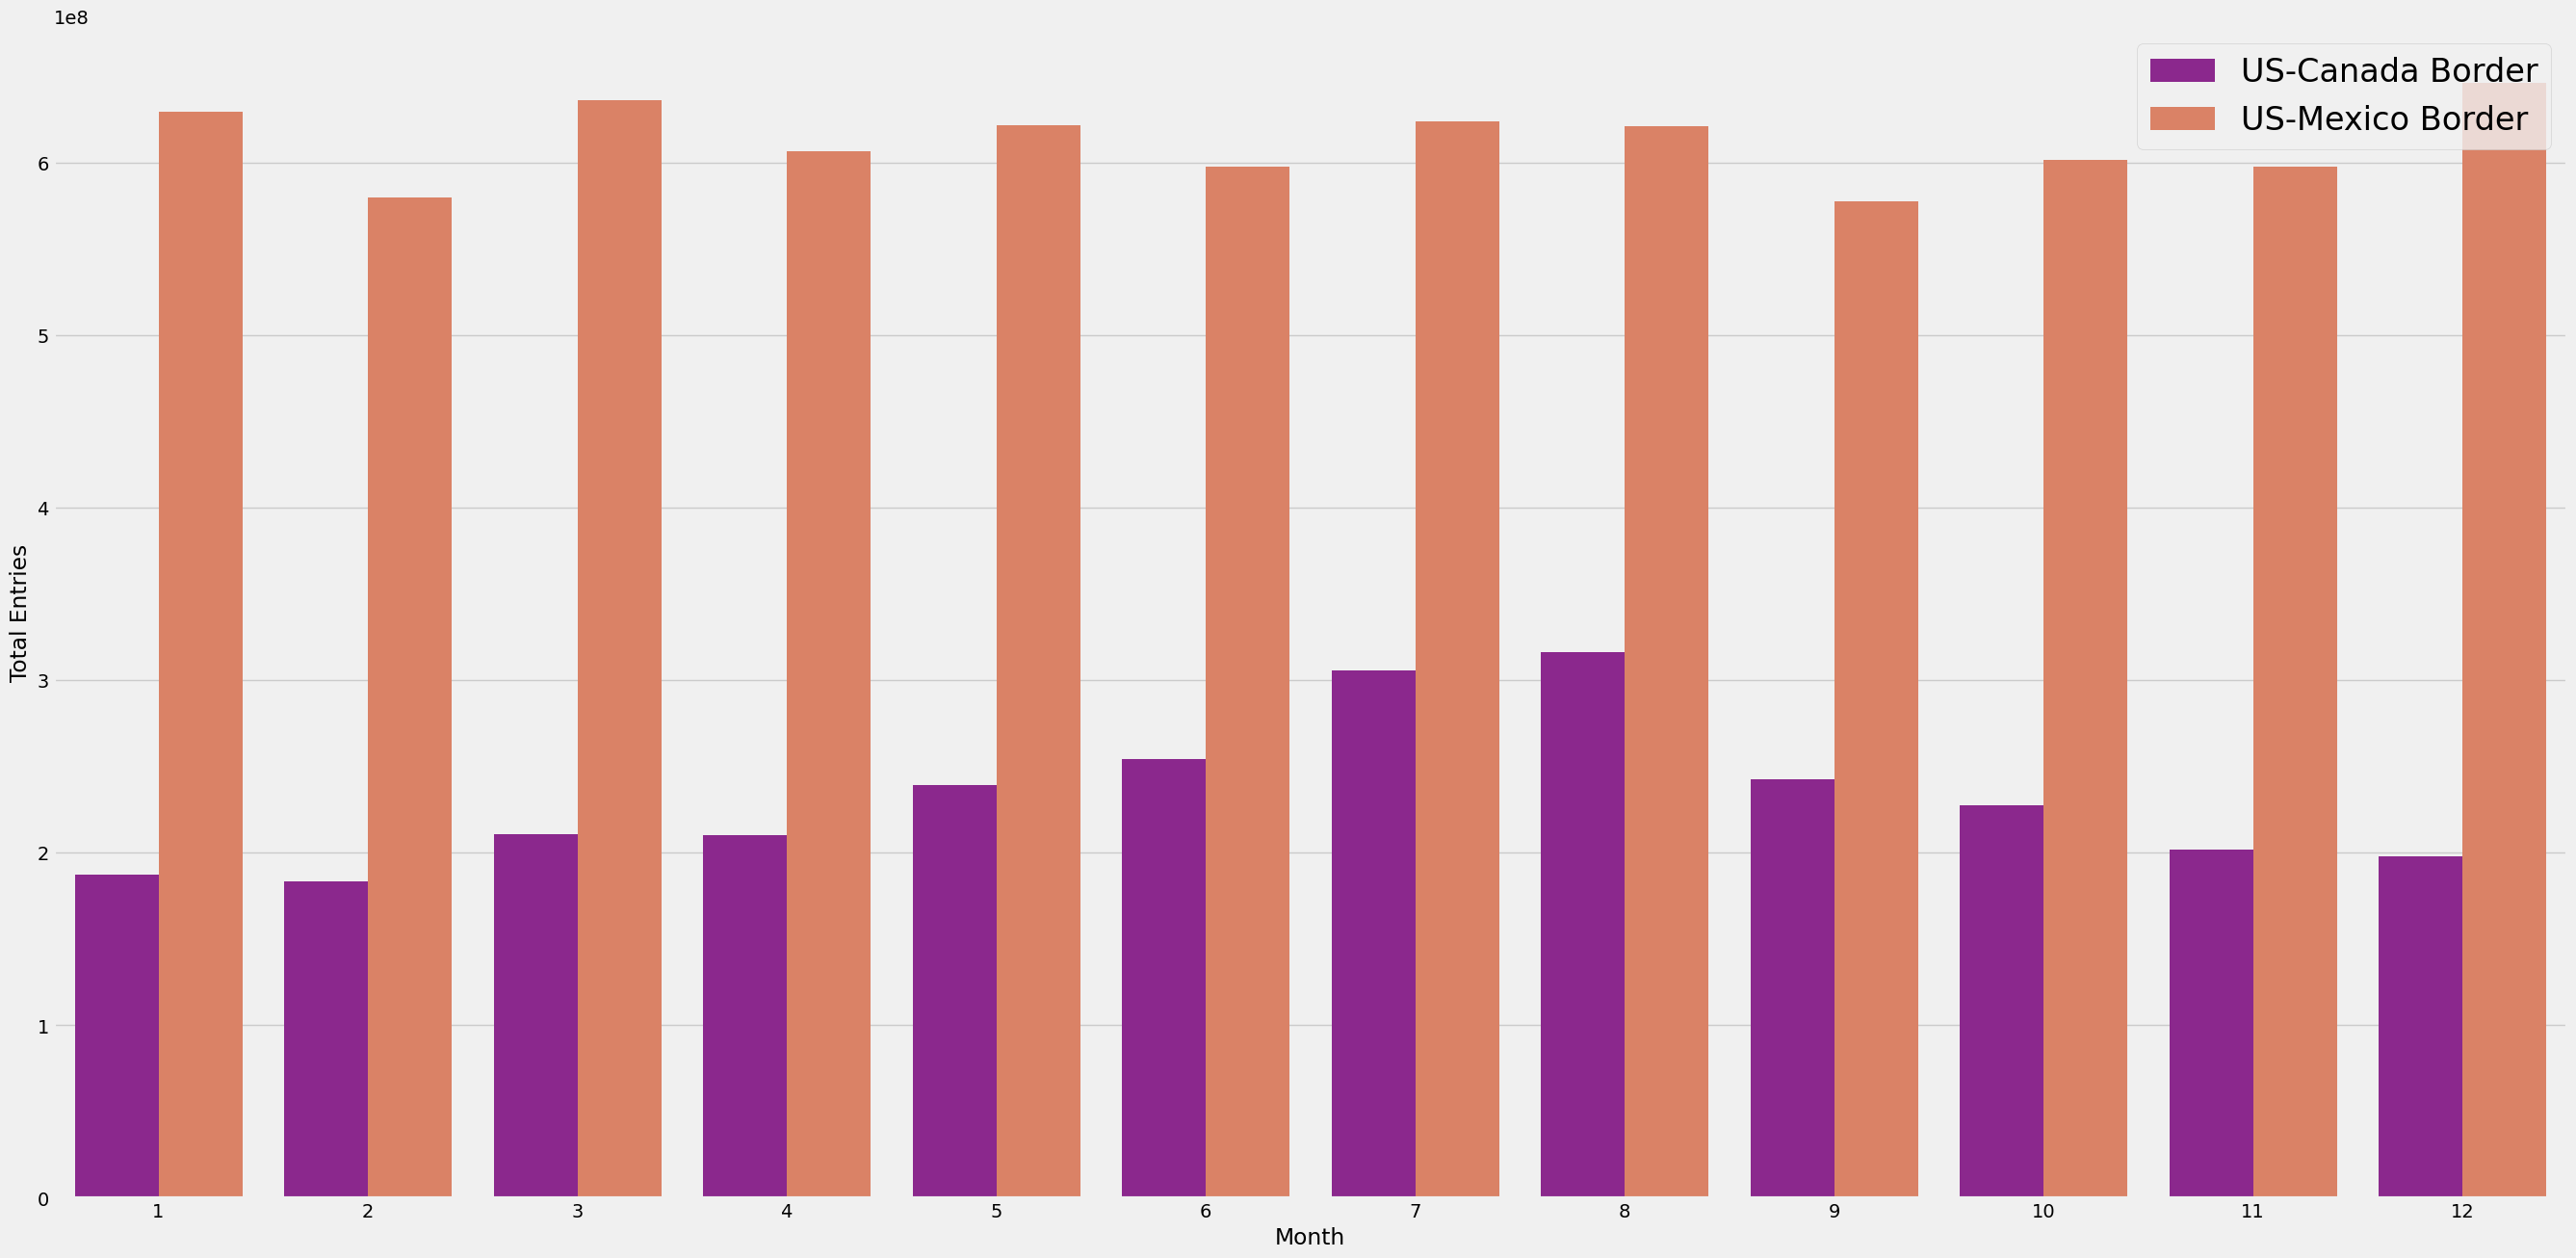

In [31]:
month_data = data.groupby(['Month', 'Border'])[
    'Total Entries'].agg(['sum']).reset_index().rename(columns={'sum': 'Total Entries'})

fig = plt.subplots(figsize=(30, 15))
sns.barplot(x='Month', y='Total Entries', hue='Border',
            data=month_data, palette='plasma')

plt.legend(fontsize='xx-large')

plt.show()

Se puede ver que en los meses que son de vacaciones de verano es cuando los canadienses entran mas a USA, mientras que los mexicanos tienen una entrada constante al pais

EMTRADAS ANUALES

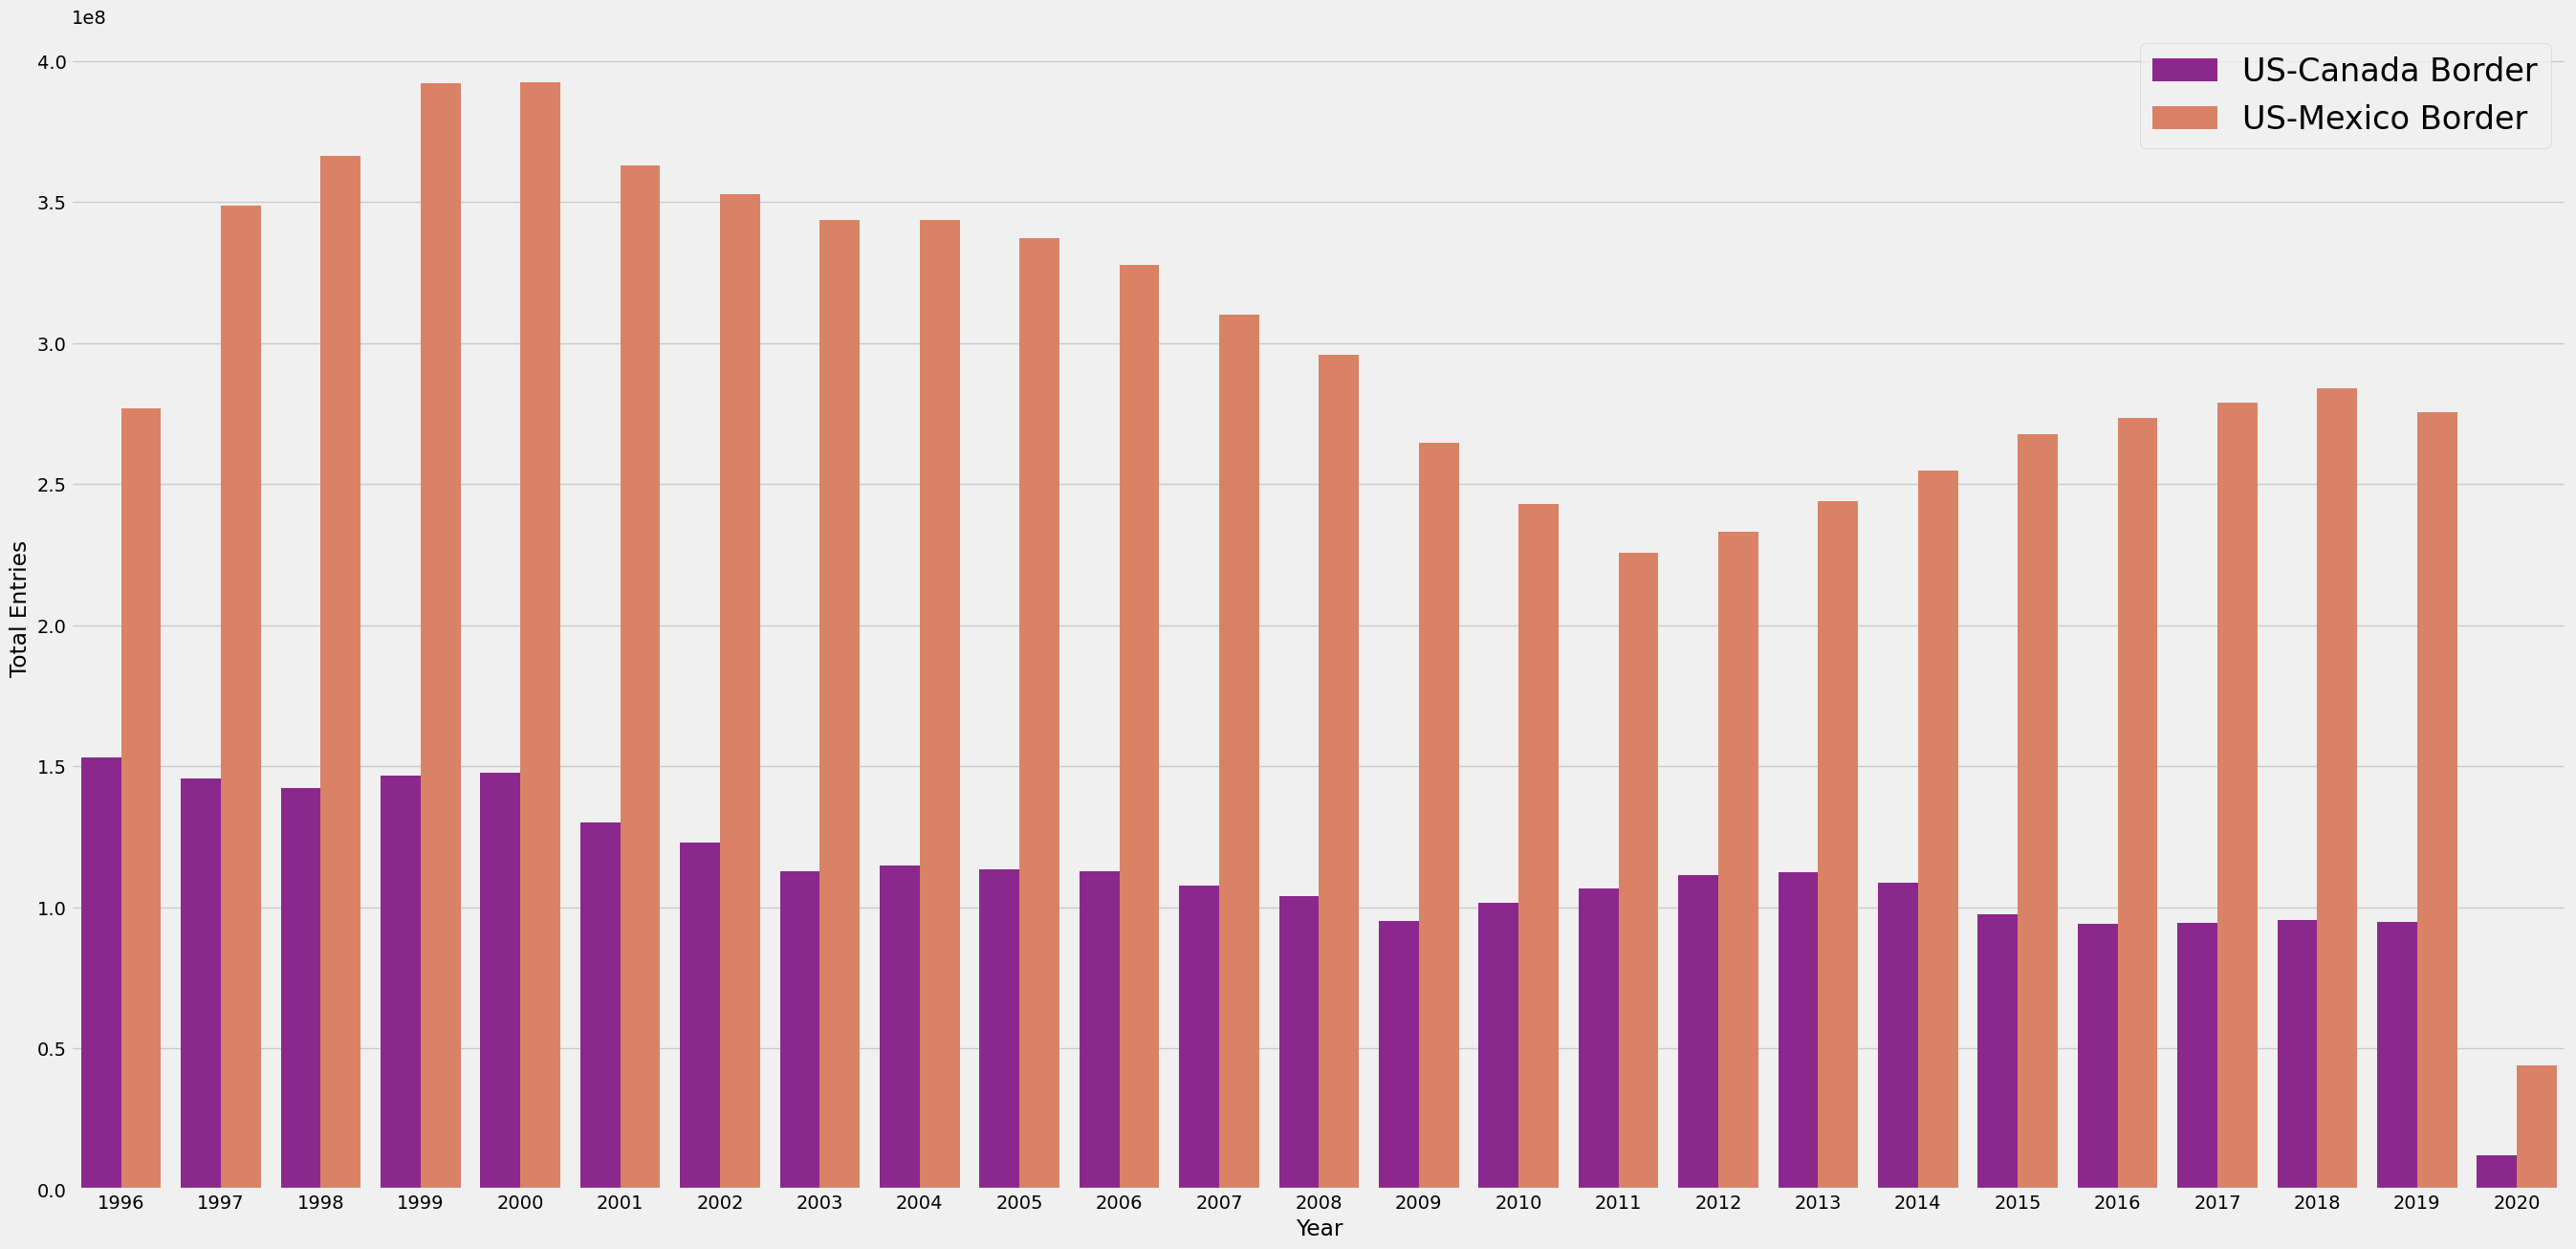

In [32]:
year_data = data.groupby(['Year', 'Border'])[
    'Total Entries'].agg(['sum']).reset_index().rename(columns={'sum': 'Total Entries'})

fig = plt.subplots(figsize=(30, 15))

sns.barplot(x='Year', y='Total Entries', hue='Border',
            data=year_data, palette='plasma')

plt.legend(fontsize='xx-large')

plt.show()

ENTRADAS POR ESTADO

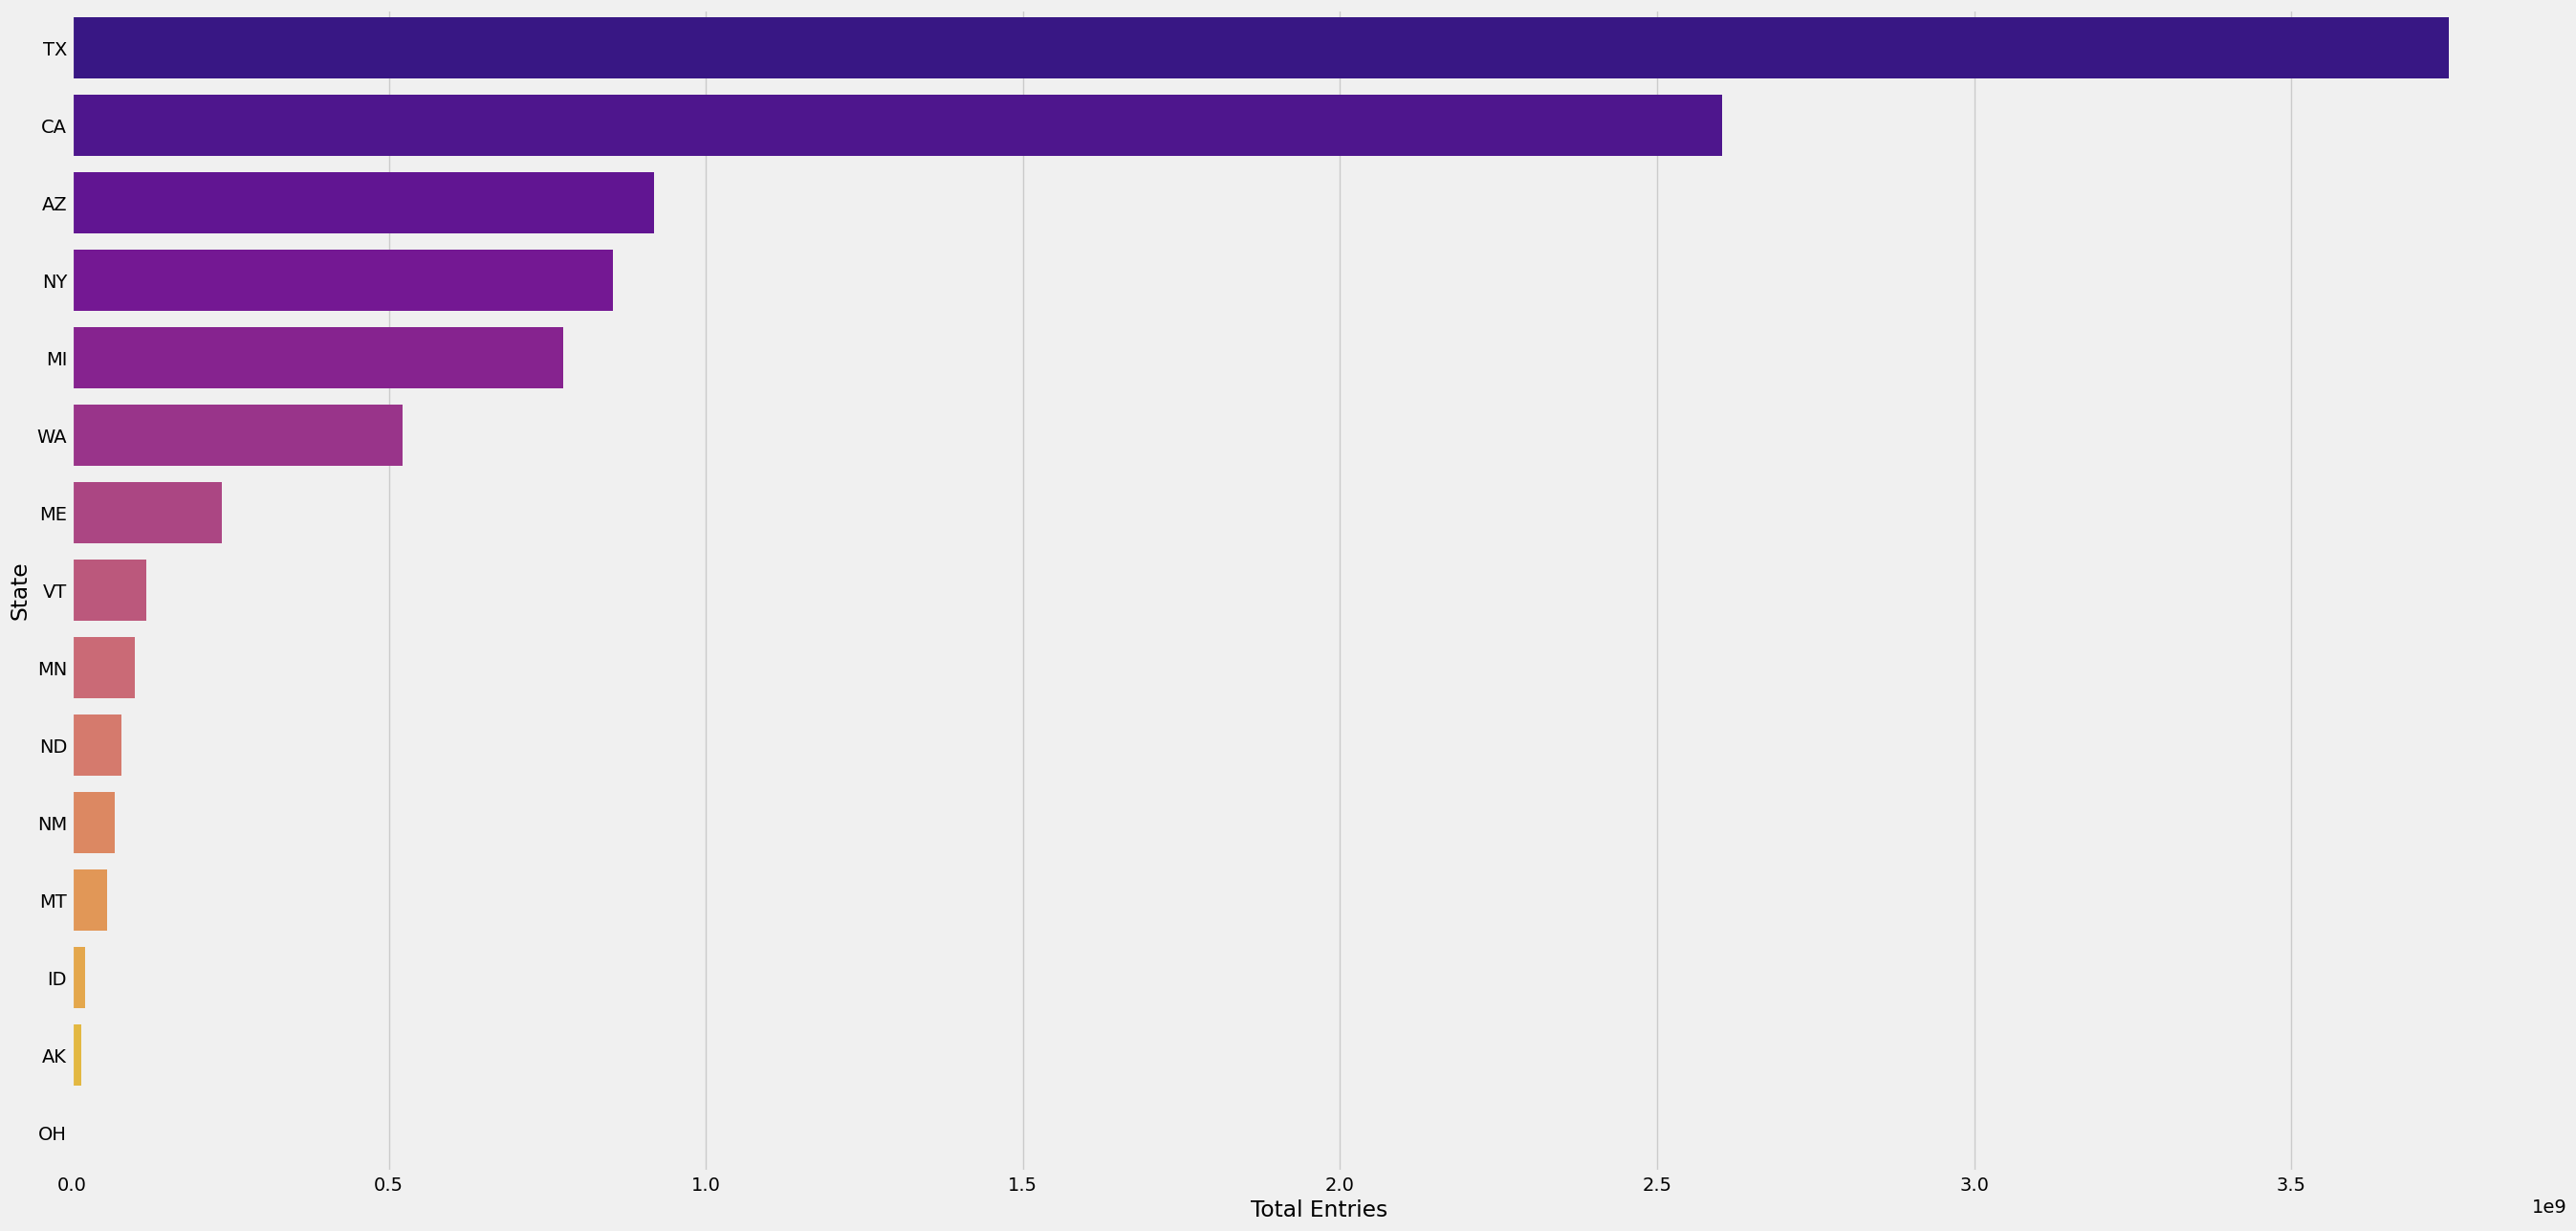

In [33]:
state_data = data.groupby(['State'])['Total Entries'].agg(
    ['sum']).reset_index().sort_values('sum', ascending=False).rename(columns={'sum': 'Total Entries'})

fig = plt.subplots(figsize=(30, 15))

sns.barplot(x='Total Entries', y='State', data=state_data, palette='plasma')

plt.show()

Cuando miramos las entradas por estado de EE. UU., podemos ver que Texas y California son los puntos de entrada más comunes para la frontera mexicana, mientras que Nueva York y Michigan son los principales puertos para las entradas canadienses.

ARIMA( Autoregressive Integrated Moving Average)

In [23]:
#datos entrenamiento
train = tseries.loc["2010":"2020"]

In [ ]:
## p representa el numero de valores pasados de la serie se usaran para predecir el valor actual

## d representa el orden de diferenciacion, es decir, cuantas veces se diferencia la serie 

## q representa el numero de residuos pasados, es decir errores que se usan para predecir el valor actual

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12)  #el ultimo parametro representa los meses del año
                for x in list(itertools.product(p, d, q))]

print('Como se verian los ejemplos de los parametros para Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Como se verian los ejemplos de los parametros para Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
## Searching for paramaters
## Disabled for better looking

#for param in pdq:
#    for param_seasonal in seasonal_pdq:
#        try:
#            mod = sm.tsa.statespace.SARIMAX(train,
#                                            order=param,
#                                            seasonal_order=param_seasonal,
#                                            enforce_stationarity=False,
#                                            enforce_invertibility=False)
#            results = mod.fit()
#            print('ARIMA{}x{}12 - AIC:{}'.format(param,
#                                                 param_seasonal, results.aic))
#        except:
#            continue

In [26]:
##modelo

model = sm.tsa.statespace.SARIMAX(train, 
                                    order=(1,1,1),
                                    seasonal_order=(1,1,1,12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0088      0.196      0.045      0.964      -0.376       0.394
ma.L1         -0.5945      0.123     -4.843      0.000      -0.835      -0.354
ar.S.L12      -0.1633      0.183     -0.890      0.373      -0.523       0.196
ma.S.L12       0.0030      0.206      0.014      0.989      -0.402       0.408
sigma2      4.103e+11   4.24e-13   9.67e+23      0.000     4.1e+11     4.1e+11


ar.L1 es el coeficiente del termino autoregresivo de orden 1
ma.L1 es el coeficiente de la media movil de orden 1
ar.S.L12 es el coeficiente del termino autoregresivo estacional(el parametro 12 que usamos hace rato)
ma.S.l12 es el coeficiente de la media movil estacional
sigma2 es la varianza de los errores (ruido del modelo)

Viendo los resultados del p value y z
Podemos ver cual de estos parametros es mas significativos que el otro usando la teoria de la hipotesis nula, si p value es mayor a 0.05, no rechazamos hipotesis nula,de lo contrario la rechazamos

ar.L1, AR.S.12, ma.S.L12 no rechazamos H0, se asume que es cero
ma.L1 rechazamos H0, la mantenemos


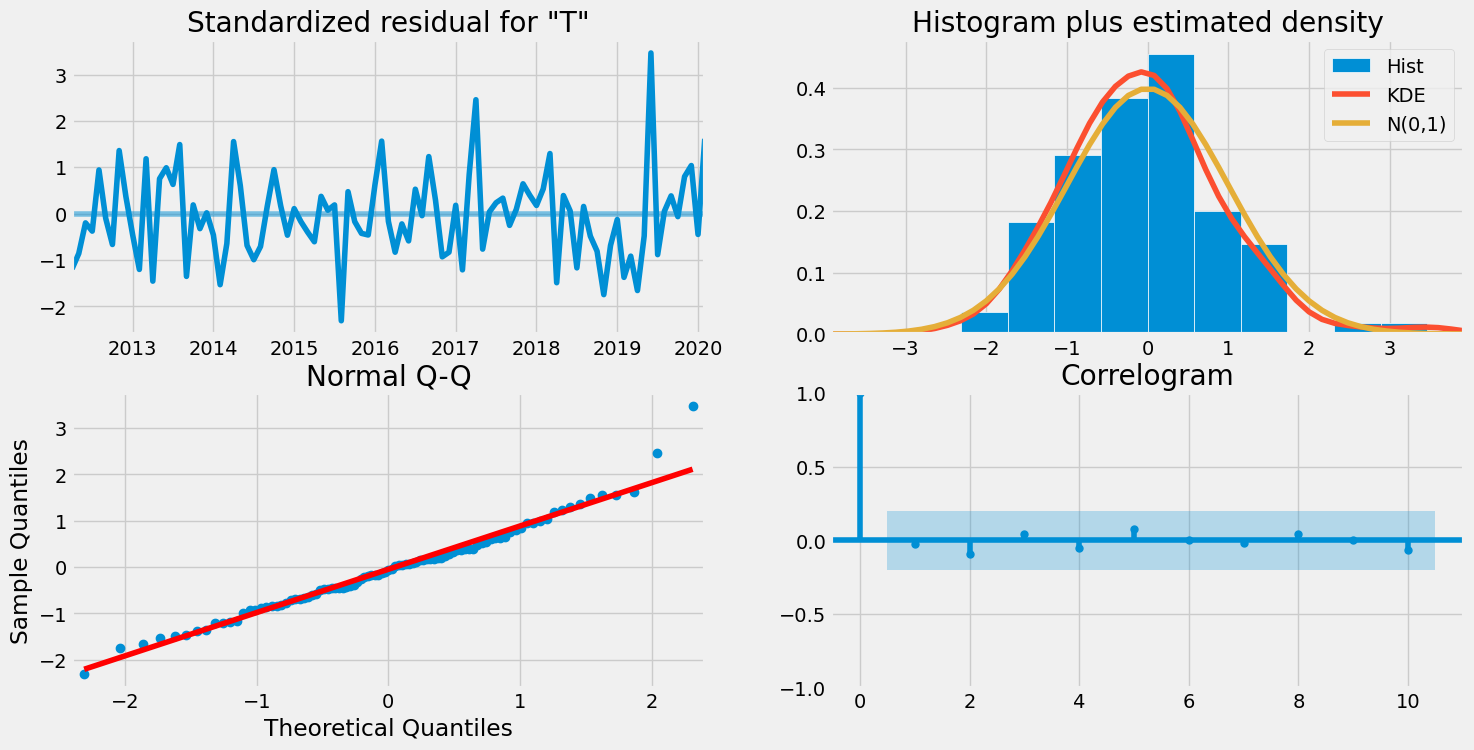

In [27]:
##valid
results.plot_diagnostics(figsize=(16,8))
plt.show()

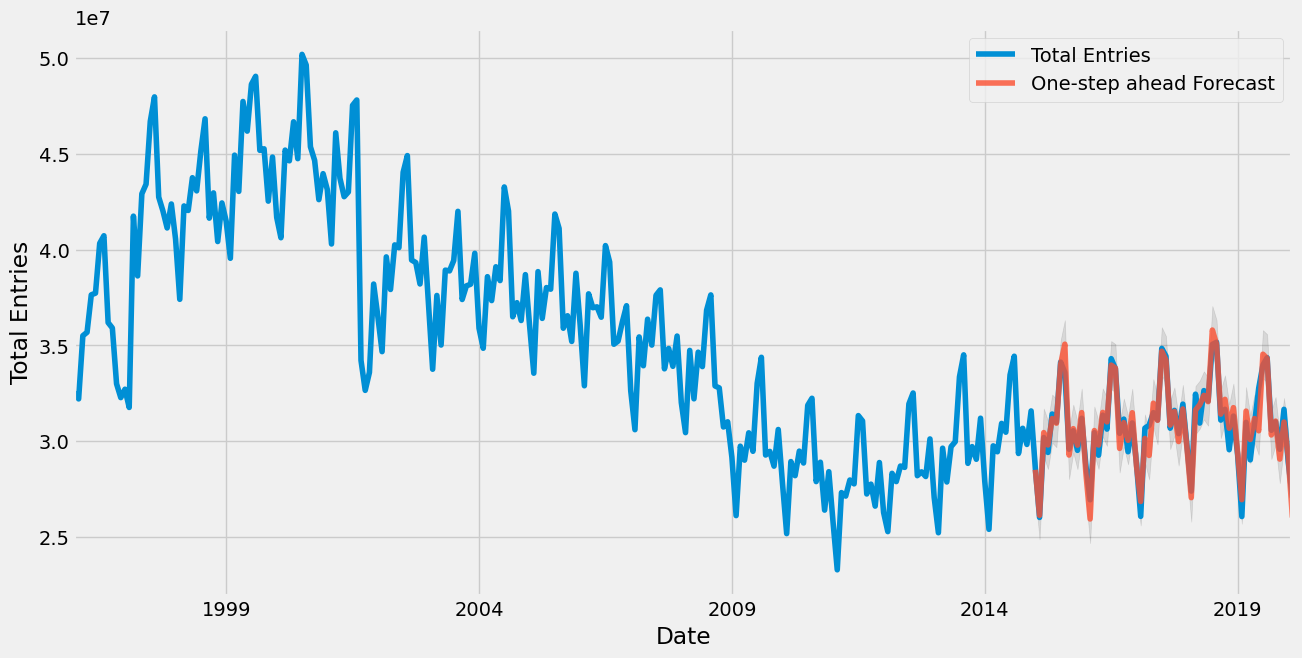

In [ ]:
# Validamos el modelo para ver si sirve para predecir

pred = results.get_prediction(
    start=pd.to_datetime('2015-01-01'), dynamic=False)

pred_ci = pred.conf_int()

ax = tseries['1996':].plot(label='observed')

pred.predicted_mean.plot(
    ax=ax, label='One-step ahead Forecast', alpha=.8, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Total Entries')

plt.legend()
plt.show()

Parece que el modelo capturo bien la estacionalidad

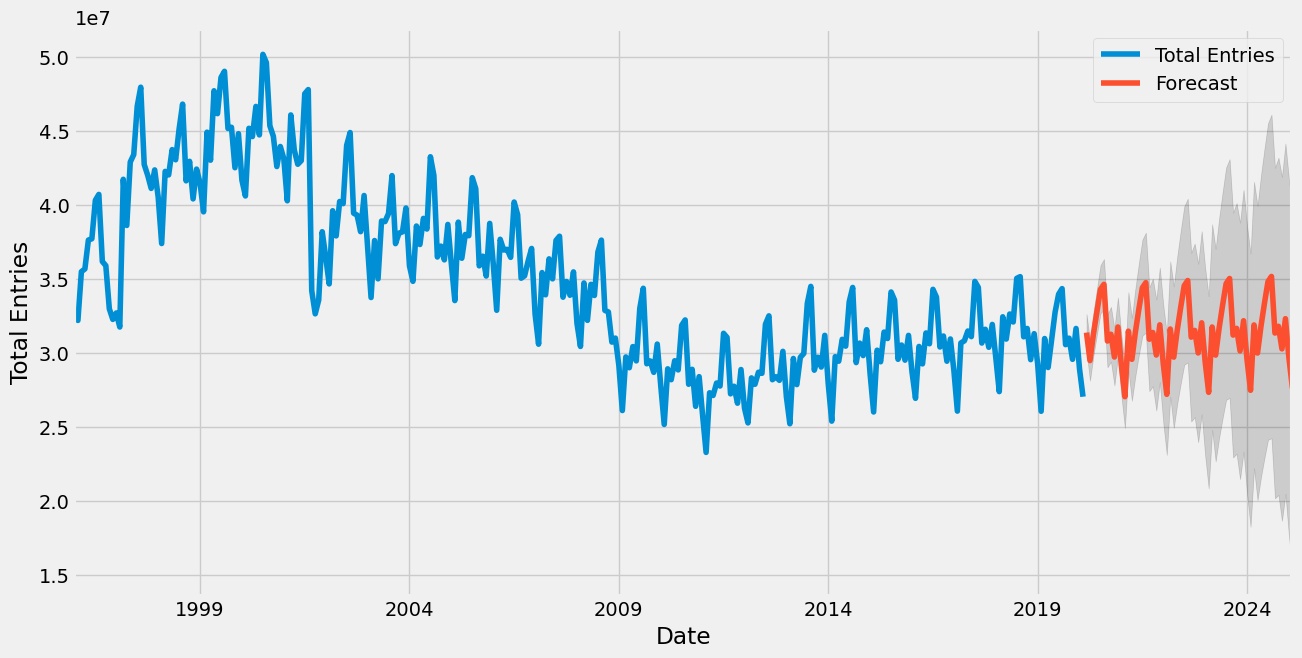

In [29]:
# mas pronosticos

pred_uc = results.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()

ax = tseries.plot(label='Total Entries', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.15)

ax.set_xlabel('Date')
ax.set_ylabel('Total Entries')

plt.legend()
plt.show()

La zona gris representa el intervalo de confianza, quiza la zona mas importante de cualquier prediccion de series de tiempo, como se puede ver, mientras mas años pasan, el intervalo se hace mas ancho, eso representa la incertidumbre.